In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import matplotlib.pyplot as plt # type: ignore
import tensorflow_hub as hub # type: ignore
import os
from IPython.display import Image # type: ignore

In [2]:
from zipfile import ZipFile 

try:
    with ZipFile("dog-breed-identification.zip", 'r') as zippedFile: 
        zippedFile.extractall(path="dataset")
except Exception as e:
    print("No file Detected!")

No file Detected!


In [3]:
labels_csv = pd.read_csv("dataset\\labels.csv")

In [4]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
labels_csv["breed"].value_counts()

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

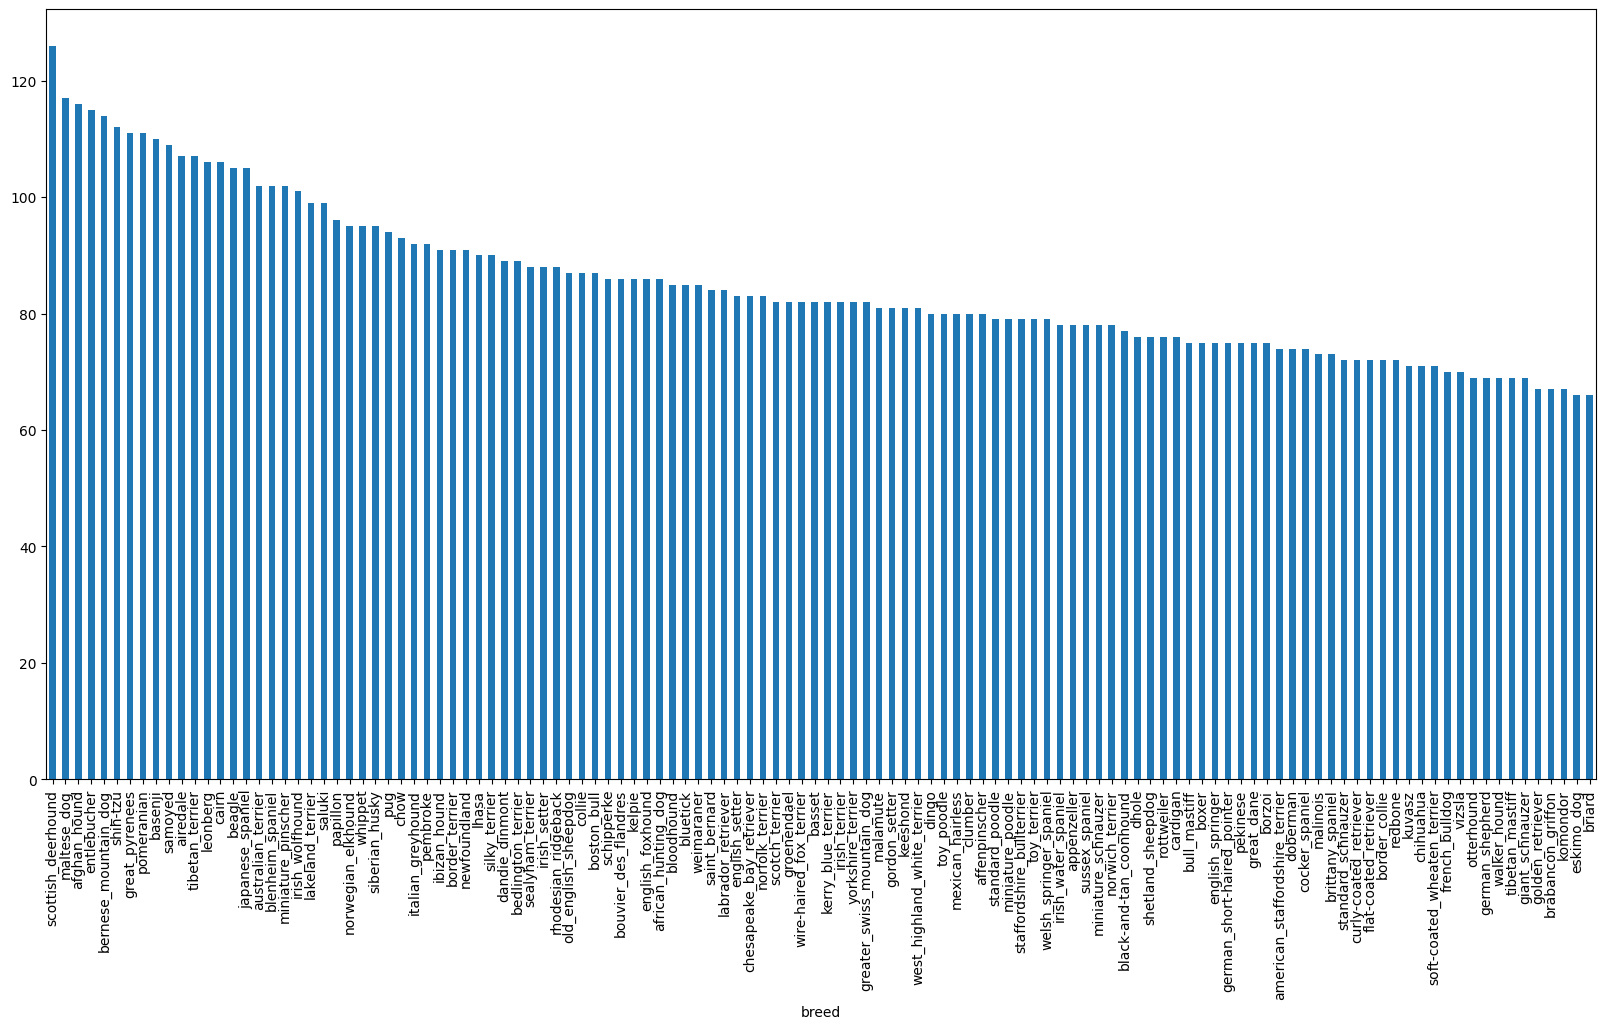

In [6]:
labels_csv["breed"].value_counts().plot(kind="bar",figsize=(20,10));

In [7]:
filenames = ["dataset//train//" + fname+ ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['dataset//train//000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dataset//train//001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dataset//train//001cdf01b096e06d78e9e5112d419397.jpg',
 'dataset//train//00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dataset//train//0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dataset//train//002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dataset//train//00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dataset//train//002a283a315af96eaea0e28e7163b21b.jpg',
 'dataset//train//003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dataset//train//0042188c895a2f14ef64a918ed9c7b64.jpg']

In [8]:
training_images_count = len(os.listdir("dataset//train//"))
filenames_count = len(filenames)

positive_msg = "Label count and image count does match!"
negative_msg = "Label count and image count doesn't match!"

msg = positive_msg if training_images_count == filenames_count else negative_msg
msg

'Label count and image count does match!'

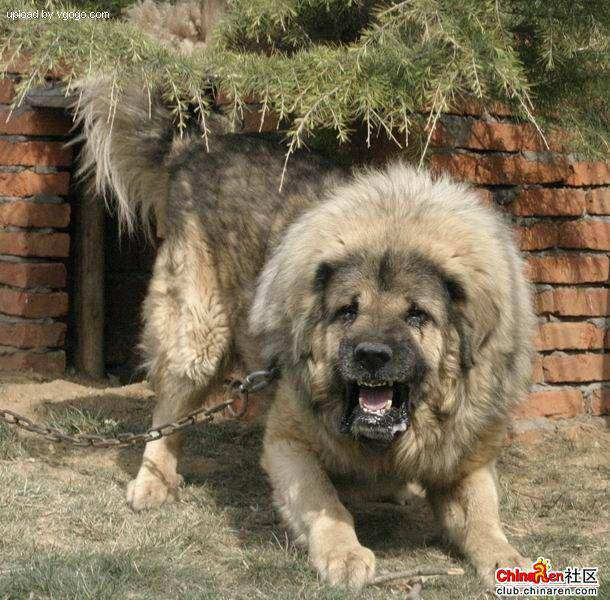

In [9]:
Image(filenames[9000])

In [10]:
labels_csv["breed"][9000]

'tibetan_mastiff'

In [11]:
labels = np.array(labels_csv["breed"])

In [12]:
len(labels)

10222

In [13]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [14]:
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [15]:
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [16]:
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

(array([19], dtype=int64),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [17]:
X = filenames
y = boolean_labels

In [18]:
NUM_IMAGES = len(filenames)

In [19]:
from sklearn.model_selection import train_test_split # type: ignore

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], random_state=42, test_size=0.2)
len(X_train), len(X_val), len(y_train), len(y_val)

(8177, 2045, 8177, 2045)

In [21]:
def process_image(IMAGE_PATH,IMAGE_SIZE=[224,224]):
    image = tf.io.read_file(IMAGE_PATH)
    image = tf.image.decode_jpeg(image,channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image,size=IMAGE_SIZE)

    return image

In [22]:
def get_image_label(IMAGE_PATH, LABEL):
    image = process_image(IMAGE_PATH)
    return image, LABEL

In [23]:
def create_data_batches(X, y=None, batch_size=32, valid_data = False, test_data = False):
    if test_data:
        print("===== Creating test data batches =====")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data_batch = data.map(process_image).batch(batch_size)
        return data_batch
    
    elif valid_data:
        print("===== Creating validation data batches =====")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch
    
    else:
        print("===== Creating training data batches =====")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.shuffle(buffer_size=len(X))
        data_batch = data.map(get_image_label).batch(batch_size)
        return data_batch

In [25]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

===== Creating training data batches =====
===== Creating validation data batches =====


In [26]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [52]:
train_images , train_labels = train_data.as_numpy_iterator().next()

In [50]:
def show_25_images(images, labels):
    plt.figure(figsize=(15,10))
    for i in range(25):
        ax = plt.subplot(5, 5, i+1)
        ax.imshow(images[i])
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis("off")

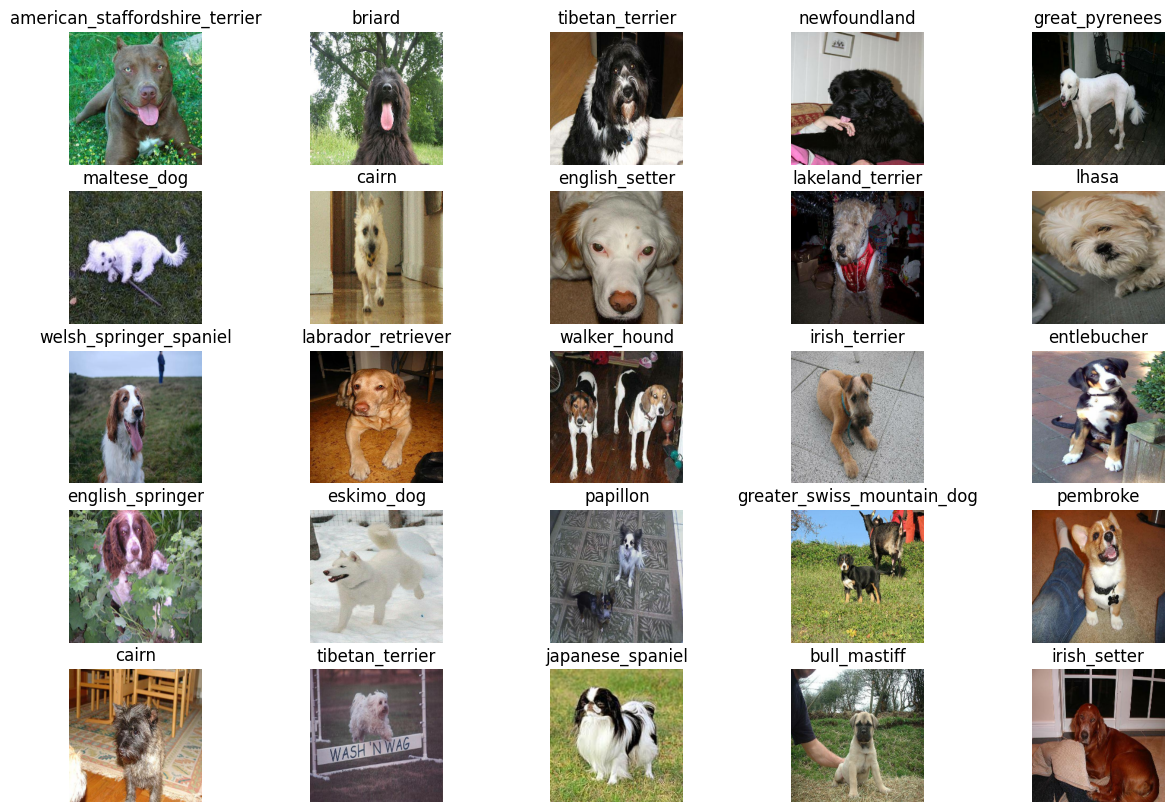

In [53]:
show_25_images(train_images , train_labels)